In [1]:
import os
import cv2
import numpy as np

test_dirs = os.listdir("./stage1_test")[1:]
test_filenames=["./stage1_test/"+file_id+"/images/"+file_id+".png" for file_id in test_dirs]
test_images=[cv2.imread(imagefile) for imagefile in test_filenames]

In [2]:
test_filenames[:5]

['./stage1_test/0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5/images/0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5.png',
 './stage1_test/0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac/images/0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac.png',
 './stage1_test/0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732/images/0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732.png',
 './stage1_test/0e132f71c8b4875c3c2dd7a22997468a3e842b46aa9bd47cf7b0e8b7d63f0925/images/0e132f71c8b4875c3c2dd7a22997468a3e842b46aa9bd47cf7b0e8b7d63f0925.png',
 './stage1_test/0ed3555a4bd48046d3b63d8baf03a5aa97e523aa483aaa07459e7afa39fb96c6/images/0ed3555a4bd48046d3b63d8baf03a5aa97e523aa483aaa07459e7afa39fb96c6.png']

In [37]:
#basic pipeline
def process(img_rgb):
    #green channel happends to produce slightly better results
    #than the grayscale image and other channels
    img_gray=img_rgb[:,:,1]#cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    #morphological opening (size tuned on training data)
    circle7=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
    img_open=cv2.morphologyEx(img_gray, cv2.MORPH_OPEN, circle7)
    #Otsu thresholding
    img_th=cv2.threshold(img_open,0,255,cv2.THRESH_OTSU)[1]
    #Invert the image in case the objects of interest are in the dark side
    if(np.sum(img_th==255)>np.sum(img_th==0)):
        img_th=cv2.bitwise_not(img_th)
    #second morphological opening (on binary image this time)
    bin_open=cv2.morphologyEx(img_th, cv2.MORPH_OPEN, circle7) 
    #connected components
    cc=cv2.connectedComponents(bin_open)[1]
    #cc=segment_on_dt(bin_open,20)
    return cc

In [38]:
test_connected_components=[process(img)  for img in test_images]

In [39]:
def rle_encoding(cc):
    values=list(np.unique(cc))
    values.remove(0)
    RLEs=[]
    for v in values:
        dots = np.where(cc.T.flatten() == v)[0]
        run_lengths = []
        prev = -2
        for b in dots:
            if (b>prev+1):
                run_lengths.extend((b + 1, 0))
            run_lengths[-1] += 1
            prev = b
        RLEs.append(run_lengths)
    return RLEs

test_RLEs=[rle_encoding(cc) for cc in test_connected_components]

In [40]:
#test submission 

with open("submission_image_processing.csv", "a") as myfile:
    myfile.write("ImageId,EncodedPixels\n")
    for i,RLEs in enumerate(test_RLEs):
        for RLE in RLEs:
            myfile.write(test_dirs[i]+","+" ".join([str(i) for i in RLE])+"\n")

In [41]:
# ok let's optimize

In [49]:
from os.path import join
import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob
import os
from skimage.io import imread
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
stage_label = 'stage1'

In [51]:
all_images = glob(os.path.join( './stage1_*', '*', '*', '*'))
img_df = pd.DataFrame({'path': all_images})
img_id = lambda in_path: in_path.split('/')[-3]
img_type = lambda in_path: in_path.split('/')[-2]
img_group = lambda in_path: in_path.split('/')[-4].split('_')[1]
img_stage = lambda in_path: in_path.split('/')[-4].split('_')[0]
img_df['ImageId'] = img_df['path'].map(img_id)
img_df['ImageType'] = img_df['path'].map(img_type)
img_df['TrainingSplit'] = img_df['path'].map(img_group)
img_df['Stage'] = img_df['path'].map(img_stage)
img_df.sample(2)

,path,ImageId,ImageType,TrainingSplit,Stage
23830,./stage1_train/c395870ad9f5a3ae651b50efab9b20c...,c395870ad9f5a3ae651b50efab9b20c3e6b9aea15d4c73...,masks,train,stage1
7843,./stage1_train/3f9fc8e63f87e8a56d3eaef7db26f1b...,3f9fc8e63f87e8a56d3eaef7db26f1b6db874d19f12abd...,masks,train,stage1


In [52]:
%%time
train_df = img_df.query('TrainingSplit=="train"')
train_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in train_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['masks'] = n_rows.query('ImageType == "masks"')['path'].values.tolist()
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    train_rows += [c_row]
train_img_df = pd.DataFrame(train_rows)    
IMG_CHANNELS = 3
def read_and_stack(in_img_list):
    return np.sum(np.stack([i*(imread(c_img)>0) for i, c_img in enumerate(in_img_list, 1)], 0), 0)

def read_hist_bw(in_img_list):
    return cv2.imread(in_img_list[0])[:,:,1]

train_img_df['images'] = train_img_df['images'].map(read_hist_bw)
train_img_df['masks'] = train_img_df['masks'].map(read_and_stack).map(lambda x: x.astype(int))
train_img_df.sample(1)

CPU times: user 1min 11s, sys: 57.6 s, total: 2min 9s
Wall time: 2min 20s


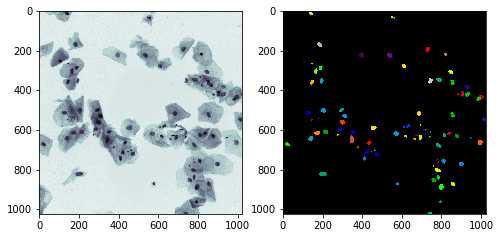

In [54]:
#analyze individual masks

for _, c_row in train_img_df.sample(1).iterrows():
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
    ax1.imshow(c_row['images'], cmap = 'bone')
    ax2.imshow(c_row['masks'], cmap = 'nipy_spectral')

In [55]:
from sklearn.model_selection import train_test_split
train_split_df, valid_split_df = train_test_split(train_img_df, 
                                                  test_size = 0.4, 
                                                  random_state = 2018,
                                                  # ensures both splits have the different sized images
                                                  stratify = train_img_df['images'].map(lambda x: '{}'.format(np.shape))
                                                 )
print('train', train_split_df.shape, 'valid', valid_split_df.shape)

train (402, 4) valid (268, 4)


In [56]:
def pipeline(img_green):
    #use 
    circle7=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
    
    img_open=cv2.morphologyEx(img_green, cv2.MORPH_OPEN, circle7)
    #Otsu thresholding
    img_th=cv2.threshold(img_open,0,255,cv2.THRESH_OTSU)[1]
    #Invert the image in case the objects of interest are in the dark side
    if(np.sum(img_th==255)>np.sum(img_th==0)):
        img_th=cv2.bitwise_not(img_th)
    #second morphological opening (on binary image this time)
    bin_open=cv2.morphologyEx(img_th, cv2.MORPH_OPEN, circle7) 
    #connected components
    cc=cv2.connectedComponents(bin_open)[1]
    #cc=segment_on_dt(bin_open,20)
    return cc


In [57]:
from skimage.morphology import label
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

In [58]:

def calculate_iou(in_df, thresh_func):
    pred_masks = valid_split_df['images'].map(thresh_func).values
    gt_masks = valid_split_df['masks'].values
    all_ious = [iou_metric(cur_gt, cur_pred, print_table=False) for cur_gt, cur_pred in 
            zip(gt_masks, pred_masks)]
    return np.mean(all_ious)

In [59]:
%%time
print('IOU', calculate_iou(valid_split_df, pipeline))

IOU 0.420544519338
CPU times: user 4.56 s, sys: 1.25 s, total: 5.81 s
Wall time: 5.85 s


In [60]:
def parametric_pipeline(img_green,
                invert_thresh_pd = 10,
                circle_size_x = 7,
                circle_size_y = 7,
                ):
    circle_size_x = np.clip(int(circle_size_x), 1, 30)
    circle_size_y = np.clip(int(circle_size_y), 1, 30)
    
    #green channel happends to produce slightly better results
    #than the grayscale image and other channels
    #morphological opening (size tuned on training data)
    circle7=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(circle_size_x, circle_size_y))
    img_open=cv2.morphologyEx(img_green, cv2.MORPH_OPEN, circle7)
    #Otsu thresholding
    img_th=cv2.threshold(img_open,0,255,cv2.THRESH_OTSU)[1]
    #Invert the image in case the objects of interest are in the dark side
    if(np.sum(img_th==255)>((invert_thresh_pd/10.0)*np.sum(img_th==0))):
        img_th=cv2.bitwise_not(img_th)
    #second morphological opening (on binary image this time)
    bin_open=cv2.morphologyEx(img_th, cv2.MORPH_OPEN, circle7) 
    #connected components
    cc=cv2.connectedComponents(bin_open)[1]
    #cc=segment_on_dt(bin_open,20)
    return cc

In [61]:
from scipy.optimize import fmin_powell
from tqdm import tqdm
base_x0_min = [0, 1, 1]
base_x0_max = [25, 30, 30]

def random_search_fmin(random_restart = 5, search_steps = 5):
    results = []
    base_x0 = (10, 7, 7) # starting point
    for _ in tqdm(range(random_restart)):
        def inv_iou_func(x0):
            try:
                score = calculate_iou(train_split_df, 
                                      lambda x: parametric_pipeline(x, *x0))
            except Exception as e:
                print('Arguments:', ' '.join(['%1.1f' % xi for xi in x0]))
                raise ValueError(e)
            print('Arguments:', ' '.join(['%1.1f' % xi for xi in x0]), 
                  'IOU: %2.3f' % score)
            return 1-score # since we are minimizing the result

        opt_params = fmin_powell(inv_iou_func, 
                          base_x0, 
                           direc = np.array([0.5, -1.5, -1.5]),
                          xtol = 0.25,
                          maxfun = search_steps)
        
        results += [(calculate_iou(train_split_df, 
                                  lambda x: parametric_pipeline(x, *opt_params)), 
                     opt_params)]
        # pick a new random spot to iterate from
        base_x0 = [np.random.choice(np.linspace(x_start, x_end, 10))
                   for x_start, x_end in zip(base_x0_min, base_x0_max)]
    n_out = sorted(results, key = lambda x: 1-x[0])
    return n_out[0][1], n_out

In [62]:
%%time
opt_params, results = random_search_fmin(5, 10)

  0%|          | 0/5 [00:00<?, ?it/s]

Arguments: 10.0 7.0 7.0 IOU: 0.421
Arguments: 10.0 7.0 7.0 IOU: 0.421
Arguments: 10.5 7.5 7.5 IOU: 0.421
Arguments: 11.3 8.3 8.3 IOU: 0.314
Arguments: 10.5 7.5 7.5 IOU: 0.421
Arguments: 10.5 7.5 7.5 IOU: 0.421
Arguments: 9.0 6.0 6.0 IOU: 0.307
Arguments: 12.9 9.9 9.9 IOU: 0.397
Arguments: 10.5 7.5 7.5 IOU: 0.421
Arguments: 11.4 8.4 8.4 IOU: 0.314
Arguments: 9.9 6.9 6.9 IOU: 0.307
Arguments: 10.7 7.7 7.7 IOU: 0.421
Arguments: 10.7 7.7 7.7 IOU: 0.421
Arguments: 9.2 6.2 6.2 IOU: 0.307
Arguments: 13.1 10.1 10.1 IOU: 0.280
Arguments: 10.7 7.7 7.7 IOU: 0.421
Arguments: 11.6 8.6 8.6 IOU: 0.314
Arguments: 10.1 7.1 7.1 IOU: 0.421


 20%|██        | 1/5 [01:31<06:06, 91.51s/it]

Arguments: 25.0 17.1 7.4 IOU: 0.214
Arguments: 25.0 17.1 7.4 IOU: 0.214
Arguments: 25.5 17.6 7.9 IOU: 0.214
Arguments: 26.3 18.4 8.8 IOU: 0.173
Arguments: 25.5 17.6 7.9 IOU: 0.214
Arguments: 25.5 17.6 7.9 IOU: 0.214
Arguments: 24.0 16.1 6.4 IOU: 0.166
Arguments: 27.9 20.0 10.4 IOU: 0.163
Arguments: 25.5 17.6 7.9 IOU: 0.214
Arguments: 26.4 18.5 8.9 IOU: 0.173
Arguments: 24.9 17.0 7.4 IOU: 0.214
Arguments: 24.9 17.0 7.4 IOU: 0.214
Arguments: 23.4 15.5 5.9 IOU: 0.246
Arguments: 21.0 13.1 3.4 IOU: 0.257
Arguments: 21.7 13.8 4.2 IOU: 0.266
Arguments: 21.7 13.8 4.2 IOU: 0.266


 40%|████      | 2/5 [02:55<04:22, 87.63s/it]

Arguments: 16.7 10.7 7.4 IOU: 0.297
Arguments: 16.7 10.7 7.4 IOU: 0.297
Arguments: 17.2 11.2 7.9 IOU: 0.353
Arguments: 18.0 12.0 8.8 IOU: 0.336
Arguments: 17.2 11.2 7.9 IOU: 0.353
Arguments: 17.2 11.2 7.9 IOU: 0.353
Arguments: 15.7 9.7 6.4 IOU: 0.359
Arguments: 13.2 7.2 4.0 IOU: 0.367
Arguments: 8.3 2.3 -0.9 IOU: 0.391
Arguments: 0.4 -5.6 -8.8 IOU: 0.169
Arguments: 8.3 2.3 -0.9 IOU: 0.391
Arguments: 8.3 2.3 -0.9 IOU: 0.391
Arguments: 6.8 0.8 -2.4 IOU: 0.391
Arguments: 4.4 -1.6 -4.8 IOU: 0.383
Arguments: 6.8 0.8 -2.4 IOU: 0.391


 60%|██████    | 3/5 [04:10<02:47, 83.61s/it]

Arguments: 2.8 7.4 4.2 IOU: 0.283
Arguments: 2.8 7.4 4.2 IOU: 0.283
Arguments: 3.3 7.9 4.7 IOU: 0.314
Arguments: 4.1 8.8 5.5 IOU: 0.307
Arguments: 3.3 7.9 4.7 IOU: 0.314
Arguments: 3.3 7.9 4.7 IOU: 0.314
Arguments: 1.8 6.4 3.2 IOU: 0.166
Arguments: 5.7 10.4 7.1 IOU: 0.298
Arguments: 3.3 7.9 4.7 IOU: 0.314
Arguments: 4.2 8.9 5.6 IOU: 0.310
Arguments: 2.7 7.4 4.1 IOU: 0.280
Arguments: 3.7 8.4 5.1 IOU: 0.299
Arguments: 3.1 7.7 4.5 IOU: 0.310
Arguments: 3.4 8.1 4.9 IOU: 0.257
Arguments: 3.2 7.9 4.6 IOU: 0.313
Arguments: 3.3 8.0 4.8 IOU: 0.318
Arguments: 3.3 8.0 4.8 IOU: 0.318
Arguments: 1.8 6.5 3.3 IOU: 0.168
Arguments: 5.7 10.4 7.2 IOU: 0.298
Arguments: 3.3 8.0 4.8 IOU: 0.318
Arguments: 4.2 8.9 5.7 IOU: 0.310
Arguments: 2.7 7.4 4.2 IOU: 0.282
Arguments: 3.7 8.4 5.1 IOU: 0.299
Arguments: 3.1 7.8 4.5 IOU: 0.310
Arguments: 3.5 8.1 4.9 IOU: 0.257
Arguments: 3.2 7.9 4.7 IOU: 0.313
Arguments: 3.4 8.0 4.8 IOU: 0.255
Arguments: 3.3 7.9 4.7 IOU: 0.314
Arguments: 3.3 8.0 4.8 IOU: 0.320


 80%|████████  | 4/5 [06:47<01:41, 101.79s/it]

Arguments: 5.6 7.4 4.2 IOU: 0.367
Arguments: 5.6 7.4 4.2 IOU: 0.367
Arguments: 6.1 7.9 4.7 IOU: 0.368
Arguments: 6.9 8.8 5.5 IOU: 0.329
Arguments: 6.1 7.9 4.7 IOU: 0.368
Arguments: 6.1 7.9 4.7 IOU: 0.368
Arguments: 4.6 6.4 3.2 IOU: 0.255
Arguments: 8.5 10.4 7.1 IOU: 0.299
Arguments: 6.1 7.9 4.7 IOU: 0.368
Arguments: 7.0 8.9 5.6 IOU: 0.329
Arguments: 5.5 7.4 4.1 IOU: 0.367
Arguments: 5.8 7.7 4.5 IOU: 0.367
Arguments: 6.4 8.3 5.1 IOU: 0.329
Arguments: 6.2 8.1 4.9 IOU: 0.294
Arguments: 6.0 7.8 4.6 IOU: 0.368
Arguments: 6.0 7.8 4.6 IOU: 0.368
Arguments: 4.5 6.3 3.1 IOU: 0.255
Arguments: 8.4 10.3 7.1 IOU: 0.299
Arguments: 6.0 7.8 4.6 IOU: 0.368
Arguments: 6.9 8.8 5.6 IOU: 0.329
Arguments: 5.4 7.3 4.1 IOU: 0.367
Arguments: 5.7 7.6 4.4 IOU: 0.367
Arguments: 6.3 8.2 5.0 IOU: 0.294
Arguments: 6.1 8.0 4.8 IOU: 0.368


100%|██████████| 5/5 [08:49<00:00, 105.99s/it]

CPU times: user 7min 21s, sys: 1min 33s, total: 8min 55s
Wall time: 8min 49s


In [76]:
print('Opt Parameters', opt_params)
print('IOU', calculate_iou(valid_split_df, 
                           lambda x: parametric_pipeline(x, *opt_params)))

Opt Parameters [ 10.11526685   7.11526685   7.11526685]
IOU 0.420544519338


In [77]:
%%time
test_df = img_df.query('TrainingSplit=="test"')
test_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in test_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    test_rows += [c_row]
test_img_df = pd.DataFrame(test_rows)    

test_img_df['images'] = test_img_df['images'].map(read_hist_bw)
print(test_img_df.shape[0], 'images to process')
test_img_df.sample(1)

65 images to process
CPU times: user 383 ms, sys: 53.9 ms, total: 437 ms
Wall time: 478 ms


In [78]:
%%time
test_img_df['masks'] = test_img_df['images'].map(lambda x: 
                                                 parametric_pipeline(x, *opt_params))

CPU times: user 134 ms, sys: 37 ms, total: 171 ms
Wall time: 173 ms


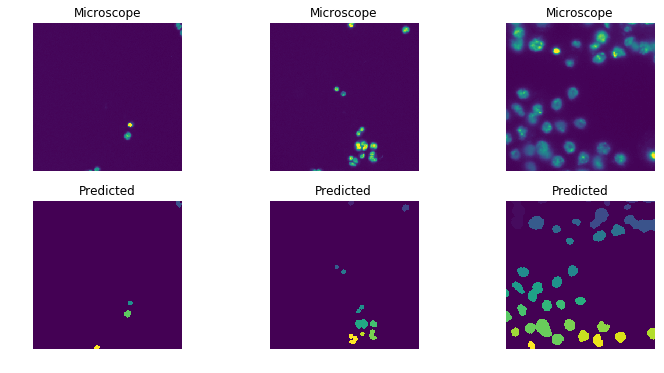

In [79]:
n_img = 3
fig, m_axs = plt.subplots(2, n_img, figsize = (12, 6))
for (_, d_row), (c_im, c_lab) in zip(test_img_df.sample(n_img).iterrows(), 
                                     m_axs.T):
    c_im.imshow(d_row['images'])
    c_im.axis('off')
    c_im.set_title('Microscope')
    
    c_lab.imshow(d_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Predicted')

In [84]:
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cut_off = 0.5):
    lab_img = label(x>cut_off)
    if lab_img.max()<1:
        lab_img[0,0] = 1 # ensure at least one prediction per image
    for i in range(1, lab_img.max()+1):
        yield rle_encoding(lab_img==i)

In [ ]:
test_img_df['rles'] = test_img_df['masks'].map(lambda x: list(prob_to_rles(x)))


In [ ]:
out_pred_list = []
for _, c_row in test_img_df.iterrows():
    for c_rle in c_row['rles']:
        out_pred_list+=[dict(ImageId=c_row['ImageId'], 
                             EncodedPixels = ' '.join(np.array(c_rle).astype(str)))]
out_pred_df = pd.DataFrame(out_pred_list)
print(out_pred_df.shape[0], 'regions found for', test_img_df.shape[0], 'images')
out_pred_df.sample(3)


In [83]:

out_pred_df[['ImageId', 'EncodedPixels']].to_csv('improvedbasicpredictions.csv', index = False)